In [ ]:
#Edited: Nora
#Edited: 2025: Sabrina
#Edited 2020: Johannes
# This is an example script for the use of the PointConcentration class/object for pointconcentration measurements
#from the windtunnel python package, showing the use of almost all available analysis functions.

# The columns in the input file are expected to be time, wtref, slow FID, fast ID, release signal and open_rate, 
# where release signal will be ignored.
# The PointConcentration class returns a DataFrame, using the standard measurement txt-file output as input

In [1]:
#Imports
import os
import glob
import sys
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Path and file names

# Add the parent directory to the path for the windtunnel package import
path_dir = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare"
sys.path.append(os.path.abspath(path_dir))
import windtunnel as wt

#Path to your input data
#path = f"{path_dir}/Users/norakaiser/Masterthesis/testdata/raw_val"
#/test_meas
path = f"{path_dir}/measurements/08.07."
# Name of your measurement files prefix
namelist = ['UBA_thesis_']

#for name in namelist: #für spezifische Messungen
#    files = [
#        'UBA_thesis_007.ts#0',
#        'UBA_thesis_009.ts#0',
#        'UBA_thesis_010.ts#0'
#    ]
    
#print("Eingelesene Dateien:", files)

#Path to your output folder for average files and plots
output_path = f"{path}/results" 

#For PointData for the functions to work the columns of the file should be: time, wtref, slow_FID, fast_FID, open_rate
#(See manual for the description of the variables)

#Name of csv file which contains ambient conditions data. Multiple diff. ambient conditions for diff datasets can be read-in at ones
#If no file given or configuration wrong, the program ressorts to try reading-in given values manually below. 
#csv_file='ambient_conditions.csv'
csv_file= f"{path}/ambient_conditions_08.csv"
parameters_PerFolder = False  #True=for each folder/namelist entry new column, False: for each ts one column entry

In [3]:
#Variables and Parameters set for all ts, if no ambient_conditions.csv file overgiven

#If at the end calculate entdimensionalised or full scale transform quantities
#Default: nd:entdimensionalise, ms:model scale, fs:full scale.    
full_scale='ms'

#Postprocessing before analysis
applyPostprocessing=True
averageInterval=60 #s  #Interval to downaverage raw time series to before analysis


uncertainty_value=None #Uncertainty of concentration, has to be calculated/estimated from the experimentator
#If None overgive no error visualized as errorbars 0.5
uncertainty_representation="percentage" #"absoluteValue"


#Source location  [mm]
x_source=0
y_source=0
z_source=0

#Source mass flow controller, calibration settings
mass_flow_controller=0.300 #[l/h]*1/100 #'X'  #Controller(settings) used, just a name placeholder for orientation, not used yet
#If calibration performed on a controller, corrects actual max. flow capacity of controller
calibration_curve=0.3     #0.3 oder 3
calibration_factor=0 #1      #

#Gas characteristics
gas_name='C2H6'           #Just placeholder name variable for orientation, not used for anything
gas_factor=1.048   #[-]    #!!! Needs to be calculate/specificate f.e. if gas changes 
mol_weight=30.07 #28.97 #Air [g/mol]


#Measurement location [mm]
x_measure=150 #855.16
y_measure= 0    #176.29
z_measure= 20     #162

#Surrounding conditions
pressure=101426.04472        #1009.38  #[hPa] ->Pa
temperature=23             #23.5  #[°C]

#Model to Reality scaling
scale=200                     #250      #Model/Reality
scaling_factor=0.5614882               #0.637       #USA1 to selected ref pos.?
ref_length=1/200              #1/250           #Lref
ref_height=100/200            #None            #Href


full_scale_wtref=10             #6         #Uref_fullscale
full_scale_flow_rate=0.002     #Q_amb[kg/s]?   #0.5   #Qv_fullscale
full_scale_temp=20             #[°C]
full_scale_pressure=101325     #[Pa]
#Q_ambient[kg/s] ->  Q[m³/s]=Q[kg/s]*R*T/(M*p)

#Variable wdir for wind direction. To be implemented in future. ##
#wdir=0
#Variable axis_range. Reserved for future implementation of axis range specification, 
#analogously to puff mode
#axis_range='auto'

In [4]:
###### Initialise concentration ts dictionary of length namelist, as well as for full scale and entdimensionalised
conc_ts = {}
conc_ts.fromkeys(namelist)
conc_ts_fs = conc_ts
conc_ts_nd = conc_ts

dict_conc_ts = conc_ts
dict_conc_nd = conc_ts
dict_conc_fs = conc_ts

data_dict = {}
data_dict.fromkeys(namelist)

{'UBA_thesis_': None}

In [5]:
#Testing nothing should be read-in already
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].x_source)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].temperature)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].mass_flow_controller)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].scaling_factor)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].gas_factor)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].full_scale_flow_rate)

StopIteration: 

In [6]:
import csv

print(f"CSV erwartet unter: {csv_file}")
if os.path.exists(csv_file):
    print("✅ CSV-Datei gefunden.")
else:
    print("❌ CSV-Datei NICHT gefunden.")
    print("Folgende Dateien sind im Ordner vorhanden:")
    for f in os.listdir(path):
        print(f)
    exit()  # wenn nicht gefunden, nicht weitermachen

print("\n📋 Lese CSV ein...")

CSV erwartet unter: /Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/measurements/08.07./ambient_conditions_08.csv
✅ CSV-Datei gefunden.

📋 Lese CSV ein...


In [7]:
#Read in ambient conditions for each folder or concentration ts from given csv file or for same conditions from manually

for name in namelist:
    if parameters_PerFolder==True:
        #Read ambient conditions from csv file only for each folder
        ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=name, input_file=csv_file)
        #Else read/use given default from cell above
        if ambient_conditions is None:
            []
        #Read ambient conditions from csv file
        else:
            x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
            ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure = wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, name)
        
    files = wt.get_files(path, name)
    print(files)
    #print(ambient_conditions)

    #Initilise Dictionary for each given name containing dimensions of nr of files ts#0-
    conc_ts[name] = {}
    conc_ts[name].fromkeys(files)
    for file in files:
        if parameters_PerFolder == False:
            #Read in ambient condition column for each ts
            ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=file, input_file=csv_file)
            #Else read/use given default from cell above
            if ambient_conditions is None:
                []
            #Read ambient conditions from csv file
            else:
                x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
                ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure = wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, file)
        
        conc_ts[name][file] = wt.PointConcentration.from_file(os.path.join(path + '/' + file))
    
        conc_ts[name][file].ambient_conditions(x_source=x_source, y_source=y_source, z_source=z_source,
                                               x_measure=x_measure, y_measure=y_measure, z_measure=z_measure,
                                               pressure=pressure,
                                               temperature=temperature,
                                               calibration_curve=calibration_curve,
                                               mass_flow_controller=mass_flow_controller,
                                               calibration_factor=calibration_factor)

#wdir,0,5

['UBA_thesis_007.ts#0', 'UBA_thesis_007.ts#1', 'UBA_thesis_008.ts#0', 'UBA_thesis_008.ts#1', 'UBA_thesis_009.ts#0', 'UBA_thesis_009.ts#1', 'UBA_thesis_010.ts#0', 'UBA_thesis_010.ts#1', 'UBA_thesis_011.ts#0', 'UBA_thesis_011.ts#1', 'UBA_thesis_012.ts#0', 'UBA_thesis_012.ts#1', 'UBA_thesis_013.ts#0', 'UBA_thesis_013.ts#1', 'UBA_thesis_014.ts#0', 'UBA_thesis_014.ts#1', 'UBA_thesis_015.ts#0', 'UBA_thesis_015.ts#1', 'UBA_thesis_016.ts#0', 'UBA_thesis_016.ts#1', 'UBA_thesis_017.ts#0', 'UBA_thesis_017.ts#1', 'UBA_thesis_018.ts#0', 'UBA_thesis_018.ts#1', 'UBA_thesis_020.ts#0', 'UBA_thesis_020.ts#1', 'UBA_thesis_020.ts#2', 'UBA_thesis_021.ts#0', 'UBA_thesis_021.ts#1', 'UBA_thesis_021.ts#2', 'UBA_thesis_021.ts#3', 'UBA_thesis_021.ts#4']


/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:62: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:63: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref
/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:62: UserWarning: P

In [8]:
#Set read-in scaling, gas and full scale information to internal class variables
for name in namelist:
    for file in files:

        conc_ts[name][file].scaling_information(scaling_factor=scaling_factor, 
                                                scale=scale,
                                                ref_length=ref_length, 
                                                ref_height=ref_height)
        
        conc_ts[name][file].tracer_information(gas_name=gas_name,
                                               mol_weight=mol_weight,
                                               gas_factor=gas_factor)
        
        conc_ts[name][file].full_scale_information(full_scale_wtref=full_scale_wtref,
                                                   full_scale_flow_rate=full_scale_flow_rate,
                                                   full_scale_temp=full_scale_temp,full_scale_pressure=full_scale_pressure)

In [9]:
#Testing everything from ambient-conditions file now read-in
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].x_source)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].temperature)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].mass_flow_controller)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].scaling_factor)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].gas_factor)
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].full_scale_flow_rate)

0.0
23.0
0.3
0.656868699877201
1.0
0.5


In [10]:
#Calculate mass flow rate, net concentration and dimensionalise concentration
for name in namelist:
    for file in files:
        
        conc_ts[name][file].convert_temperature()
        conc_ts[name][file].calc_wtref_mean()
        
        conc_ts[name][file].calc_model_mass_flow_rate(usingMaxFlowRate="True",applyCalibration="False")
        conc_ts[name][file].calc_net_concentration()

        #conc_ts[name][file].clear_zeros()  #Remove values net_concentration =< 0 from dataset !noise
        conc_ts[name][file].calc_c_star()

        conc_ts[name][file].calc_full_scale_concentration() #Try

In [11]:
#Test c*star output
print(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].c_star)

0        0.001759
1        0.000844
2        0.001060
3        0.000273
4        0.000843
           ...   
29995    0.000642
29996    0.000546
29997    0.002275
29998    0.003934
29999    0.002552
Length: 30000, dtype: float64


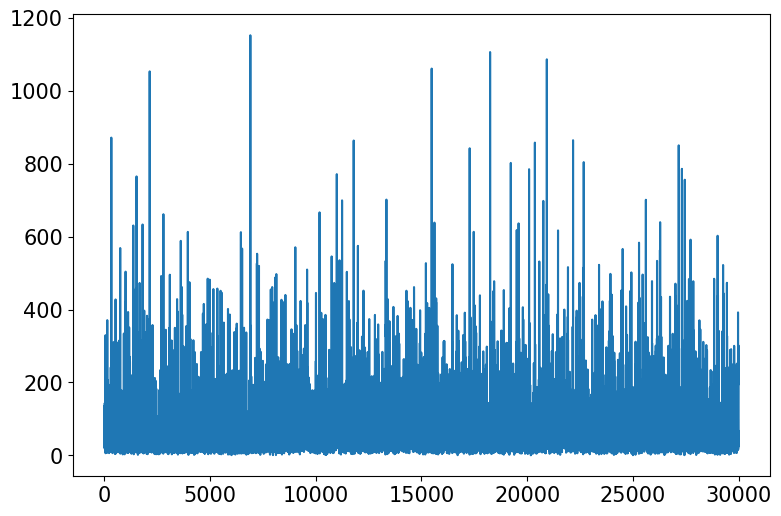

In [12]:
plt.plot(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration)

In [13]:
#Options for Outputting data in full-scale, model scale, and non-dimensionally.

for name in namelist:
    for file in files:
        
        if full_scale == 'ms':
            dict_conc_ts = conc_ts
            
        elif full_scale == 'fs':
            dict_conc_ts = conc_ts_fs
            dict_conc_ts[name][file].to_full_scale()
            
        elif full_scale == 'nd':
            dict_conc_ts = conc_ts_nd
            dict_conc_ts[name][file].to_non_dimensional()
        else:
            print(
                "Error: invalid input for full_scale. Data can only be computed in model scale (full_scale='ms'), full scale (full_scale='fs'), or non-dimensionally (full_scale=nd).")
        

In [14]:
#Saving PointConcObject calculates new quantities(f.e. c*star) to files
#At the moment path hardcoded to windwos, but still ok
for name in namelist:
    for file in files:

        # Zielverzeichnis: im output_path
        out_dir = os.path.join(output_path, 'Point_Data', name.split('.')[0])

        wt.check_directory(out_dir)

        dict_conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].__check_sum = 8
        # alternativ evtl.: dict_conc_ts[name][file].__check_sum = 8

        if full_scale == 'ms':
            dict_conc_ts[name][file].save2file_ms(file, out_dir=out_dir)
        elif full_scale == 'fs':
            dict_conc_ts[name][file].save2file_fs(file, out_dir=out_dir)
        elif full_scale == 'nd':
            dict_conc_ts[name][file].save2file_nd(file, out_dir=out_dir)
        else:
            print(
                "Error: invalid input for full_scale. "
                "Data can only be computed in model scale (ms), full scale (fs), or non-dimensionally (nd)."
            )

In [15]:
#Saving averages and stats to files under folder Point_Data_avg/Point_Data_stats
#At the moment path hardcoded to windows, but still ok

#Stats Full ausgabe: Mean, percentile 95, percentile 5, peak2Mean 
for name in namelist:
    for file in files: 

        avg_dir = os.path.join(output_path, 'Point_Data_avg', name.split('.')[0])
        stats_dir = os.path.join(output_path, 'Point_Data_stats', name.split('.')[0])

        wt.check_directory(avg_dir)
        wt.check_directory(stats_dir)

        dict_conc_ts[name][file].save2file_avg(file, out_dir=avg_dir)
        dict_conc_ts[name][file].save2file_fullStats(file, out_dir=stats_dir)


In [16]:
if not hasattr(conc_ts[name][file], "concentration"):
    if hasattr(conc_ts[name][file], "net_concentration"):
        setattr(conc_ts[name][file], "concentration", conc_ts[name][file].net_concentration)
    else:
        print("⚠️ Kein concentration oder net_concentration gefunden.")


/var/folders/36/9ccng9610ds2v_vzjl771fh80000gn/T/ipykernel_81072/3276385545.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  setattr(conc_ts[name][file], "concentration", conc_ts[name][file].net_concentration)


In [17]:
print(conc_ts[name][file].concentration)
print("Shape:", conc_ts[name][file].concentration.shape)
print("NaNs vorhanden:", np.any(np.isnan(conc_ts[name][file].concentration)))
print("Min/Max:", np.min(conc_ts[name][file].concentration), "/", np.max(conc_ts[name][file].concentration))


0        16.442144
1        21.772867
2        42.642349
3        27.453236
4        35.607092
           ...    
29995    45.112314
29996    48.067737
29997    90.394536
29998    36.706898
29999    25.996537
Length: 30000, dtype: float64
Shape: (30000,)
NaNs vorhanden: False
Min/Max: -0.3411719999999998 / 1167.160059


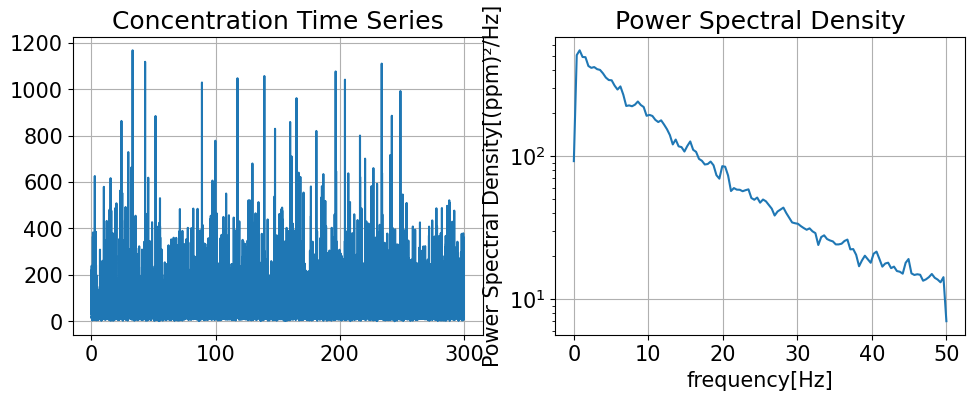

{'wtref mean': 5.137282342133333,
 'wtref std': 0.03925422295934215,
 'wtref turbulence intensity': 0.007641048388055162,
 'peakToMeanRatio': 17.006822578923448,
 'std_concentration': 74.43448027013508,
 'intermittency factor for1.5': 0.17996666666666666}

In [18]:
#Concentration fluctuation analysis 
#Intermittency based on threshold, peak2Mean, concentration variance spectral density distribution

#Seettings intermittency calculation
threshold_type="ratio" #ratio, absolute
threshold_method="mean" #mean, std
intermittency_threshold=1.5 #-> if type=ratio,method mean, threshold=threshold*mean(concentration), if type=absolute: threshold=threshold

conc_ts[name][file].analyze_concentration_fluctuations(dimensionless="False",
                                                       intermittency_threshold=intermittency_threshold,threshold_method=threshold_method)
#power(variance) of concentration changes for different frequencies/timer interval lengths 
#Low-frequency peak: Slow, gradual concentration changes
#High-frequency peak: Rapid, quick concentration fluctuations
#Broad spectrum: Mixed or complex concentration dynamics

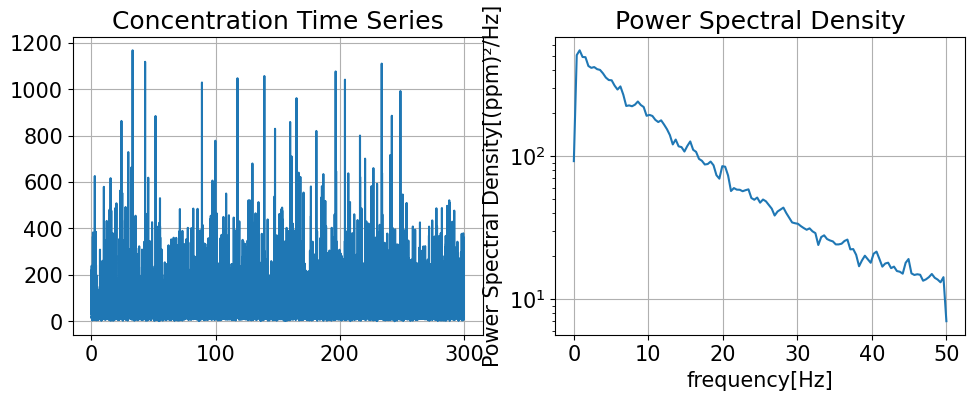

{'wtref mean': 5.137282342133333,
 'wtref std': 0.03925422295934215,
 'wtref turbulence intensity': 0.007641048388055162,
 'peakToMeanRatio': 17.006822578923448,
 'std_concentration': 74.43448027013508,
 'intermittency factor for1.5': 0.17996666666666666}

In [19]:
# Vorher explizit Intermittency berechnen – damit threshold richtig gesetzt wird
conc_ts[name][file].calculate_intermittency(
    threshold_type="ratio",         # oder "absolute"
    threshold_method="mean",        # oder "std"
    threshold_factor=1.5,
    dimensionless=False
)

# Jetzt sollte analyze... ohne Fehler laufen
conc_ts[name][file].analyze_concentration_fluctuations(
    dimensionless=False,
    threshold_type="ratio",
    threshold_method="mean",
    intermittency_threshold=1.5)

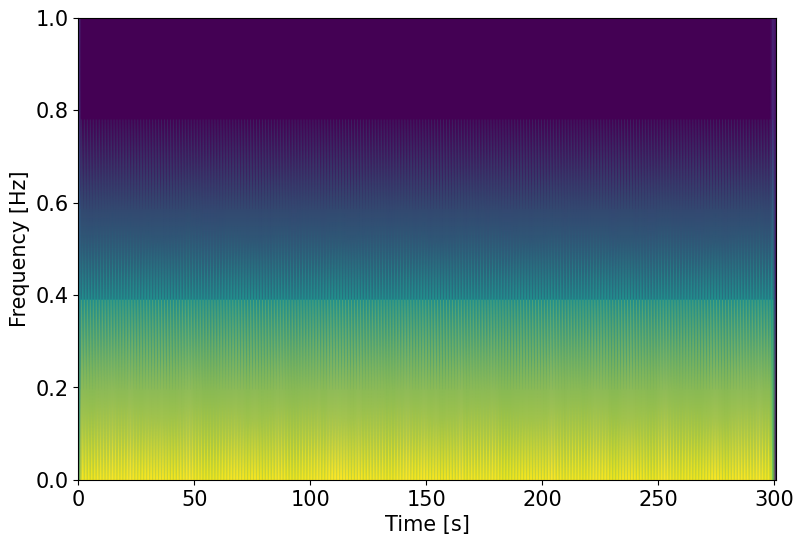

In [20]:
#Testing incorporation of STJF for intermittency (Sequential time join fourier, leaves time domain intact)
#STFTs calculates sequential FFTs and can be used as a way of quantifying the change of a spectrum over time.
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

#0.005 6.0045 2.276105 12.835903 2.381506 3.91625 
#0.015 5.992015 1.911356 28.29813 2.390326 3.914681 
sampling_rate = 100#Hz

f, t, Zxx = stft(conc_ts[name][file].wtref, fs=sampling_rate, nperseg=256, noverlap=128)

plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
#plt.yscale('log')  #logarithmic scale?
plt.ylim(0,1)
#plt.colorbar(label='Magnitude')
plt.show()

In [21]:
#For completeness also calculate further characteristic metrics of flow/ wind velocity time series (from wtref ts), skewness ..
#print(conc_ts[name][file].calculate_turbulence_intensity(dimensionless="True",returnDistribution="False",returnMetrics="True"))

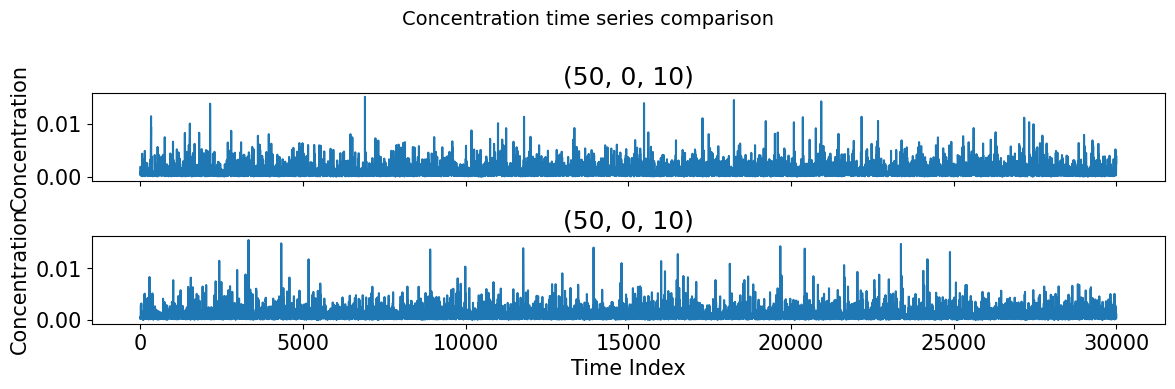

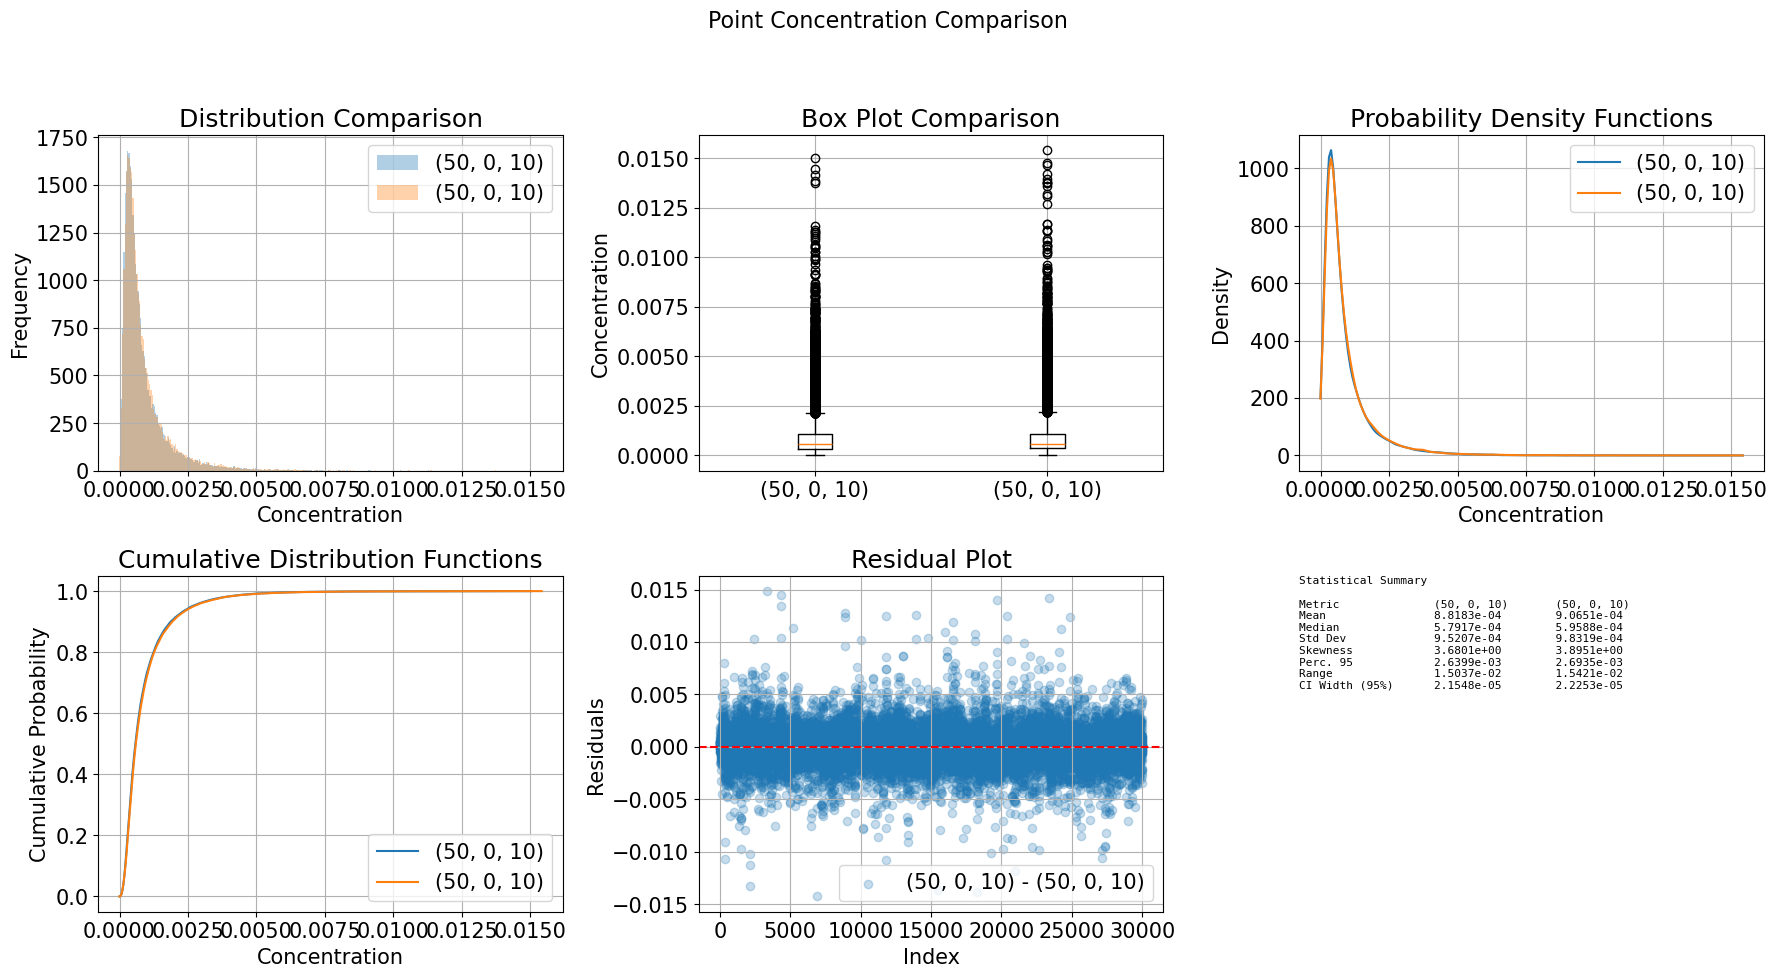


Detailed Comparison:
Mean: (50, 0, 10) = 0.0009, (50, 0, 10) = 0.0009
Std Dev: (50, 0, 10) = 0.0010, (50, 0, 10) = 0.0010
Skewness: (50, 0, 10) = 3.6801, (50, 0, 10) = 3.8951
Percentile 95: (50, 0, 10) = 0.0026, (50, 0, 10) = 0.0027
Turbulence Intensity v: (50, 0, 10) = 0.0080, (50, 0, 10) = 0.0076
Turbulence Intensity c: (50, 0, 10) = 1.0797, (50, 0, 10) = 1.0846
Pearson r (vs Dataset 1): (50, 0, 10) = N/A, (50, 0, 10) = 0.0033
Spearman rho (vs Dataset 1): (50, 0, 10) = N/A, (50, 0, 10) = 0.0088
RMSE (vs Dataset 1): (50, 0, 10) = N/A, (50, 0, 10) = 0.0014
Range (Max - Min): (50, 0, 10) = 0.0150, (50, 0, 10) = 0.0154
95% CI Width: (50, 0, 10) = 0.0000, (50, 0, 10) = 0.0000
Median: (50, 0, 10) = 0.0006, (50, 0, 10) = 0.0006
IQR (Q3 - Q1): (50, 0, 10) = 0.0007, (50, 0, 10) = 0.0007


In [30]:
from windtunnel.concentration.CompareDatasets import compare_point_concentrations_3
#Give overview/comparison for the data, one plot including of of the plots choosen in the list "functionsForOverview
#Means, Pdf, Cdf, PowerDensity: Number of ts does not matter that much
#Scatterplot: use only 2 ts
#Histogram, Boxplot: would also recommend not to many, because of overlapping of the histograms for comparison, space for the boxplots..

#functionsForOverview = ["all"] #defaul -> all of the available plots
#all_plot_types = [
#        "Histogram", "Pdf", "Cdf", "Means", "BoxPlot", 
#        "QuantilPlot", "ScatterPlot", "ResidualPlot", "Autocorrelation"
#    ]
    
functionsForOverview = [
    "Histogram",
    "BoxPlot",
    "Pdf",
    "Cdf",
    "ResidualPlot",
    "StatisticalSummary"
        ]

#Choose which concentration time series/PointObjekts to show in the overview/comparison plot
DataPointsConc = [
    conc_ts[namelist[0]]["UBA_thesis_007.ts#0"],
    conc_ts[namelist[0]]["UBA_thesis_021.ts#4"],
    #conc_ts[namelist[0]]["UBA_thesis_010.ts#0"]
]

labels = [f"({dp.x:.0f}, {dp.y:.0f}, {dp.z:.0f})" for dp in DataPointsConc]

compare_point_concentrations_3(DataPointsConc,functionsForOverview, labels=labels)


In [31]:
#Start visualisation single plots, adjustable
#ReadIn/Choose data (PointObjects) from the analysis above, to use for the separat plot visualisations, import plotting functions

#Specify files
DataPointsConc = [
    conc_ts[namelist[0]]["UBA_thesis_007.ts#0"],
    conc_ts[namelist[0]]["UBA_thesis_009.ts#0"],
    conc_ts[namelist[0]]["UBA_thesis_010.ts#0"]
]

#All files read-in

#DataPointsConc=[]
#for i in range(0,len(files)):
#    DataPointsConc.append(
#        conc_ts[namelist[0]][files[i]]
#    )
#    print(files[i])
#Labels    
labels = [f"Dataset {i}" for i in range(1,len(DataPointsConc)+1)]

print(labels)
print(len(DataPointsConc))
print(DataPointsConc)

#Load all functions for plotting
from windtunnel.concentration.CompareDatasets import *

['Dataset 1', 'Dataset 2', 'Dataset 3']
3
[PointConcentration (x=50.0, y=0.0, z=10.0), PointConcentration (x=175.0, y=0.0, z=10.0), PointConcentration (x=500.0, y=0.0, z=10.0)]


In [32]:
means = [dp.net_concentration.mean() for dp in DataPointsConc]

for label, mean_val in zip(labels, means):
    print(f"{label}: mean = {mean_val:.2f}")


Dataset 1: mean = 67.55
Dataset 2: mean = 97.11
Dataset 3: mean = 32.19


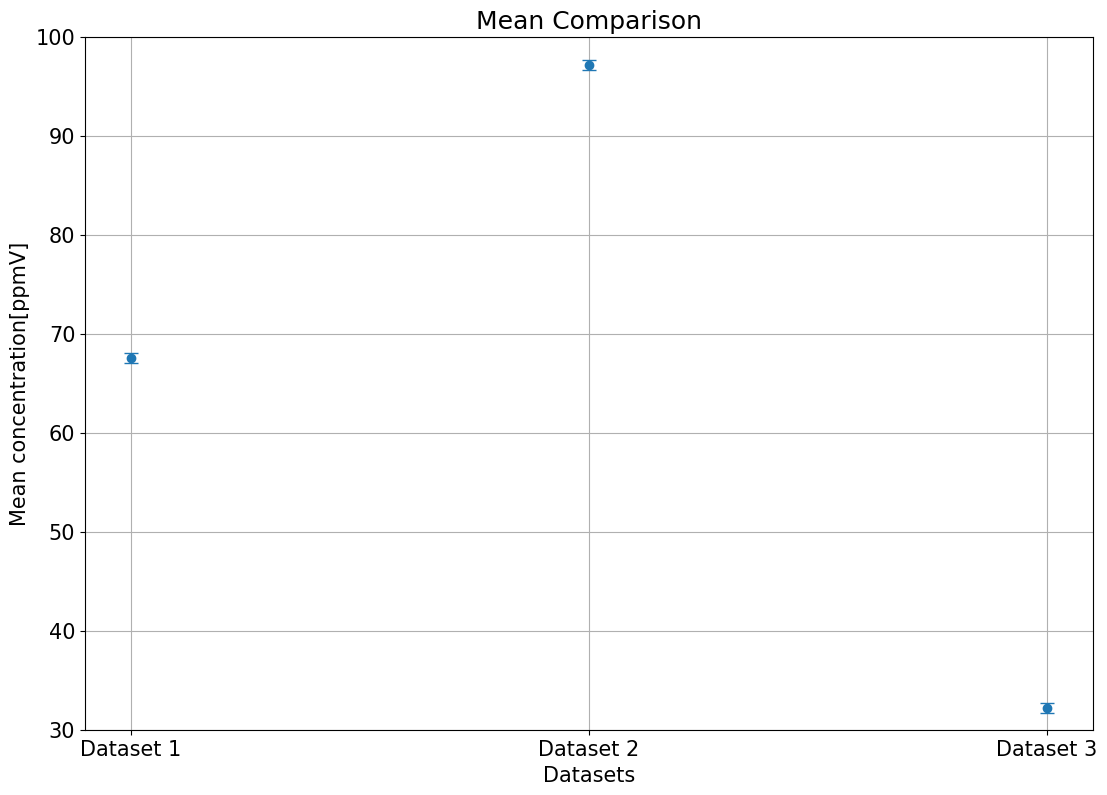

In [33]:
xLabel="Datasets"
yLabel="Mean concentration[ppmV]" 
dimensionless="False"
xAchse = None 
yAchse=(30,100) #None 
error_values=0.5 #[0.5,0.2,0.1] #For error values overgive one number which is cast to all values, or an array if specify different errors for each measurements
errorType="absolute"
test = create_means(DataPointsConc,error_values,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=xAchse,yAchse=yAchse)
#plt.savefig("Mean_comparison.png",test) #To save image

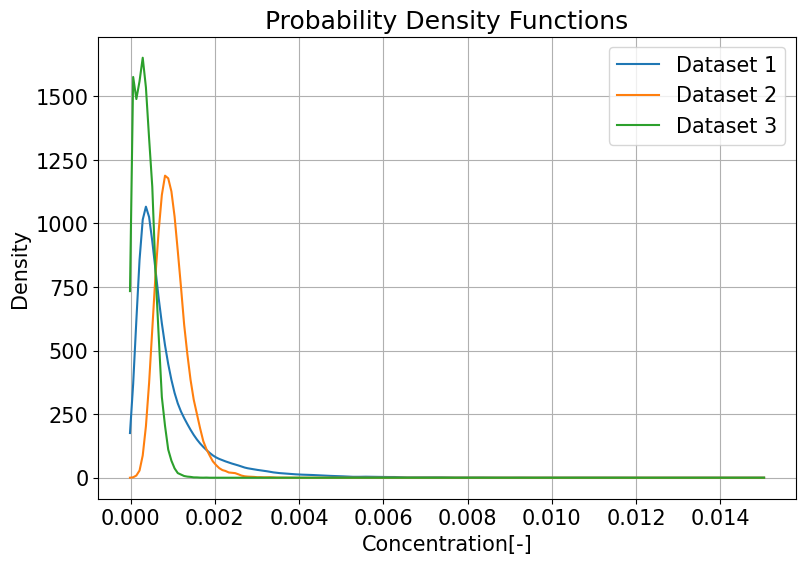

In [34]:
xLabel="Concentration[-]"
yLabel="Density"
dimensionless="True"
create_pdf(DataPointsConc,dimensionless="True",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

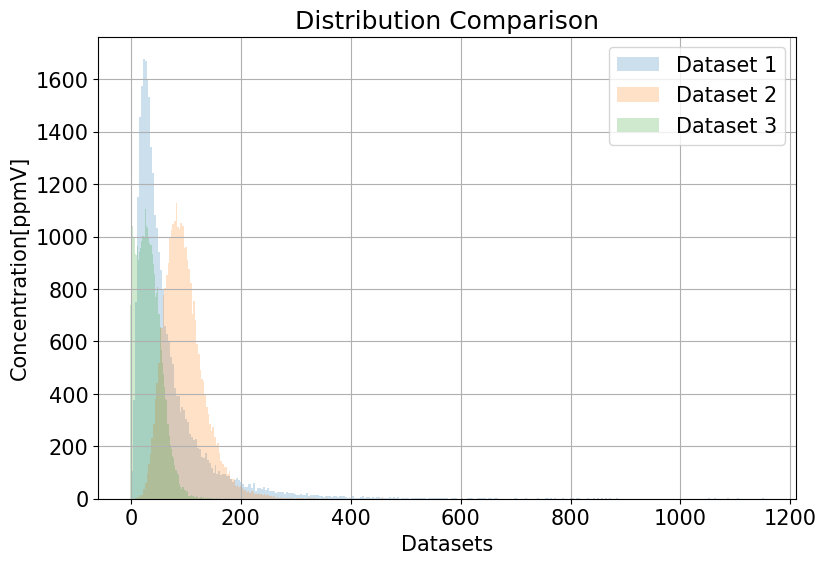

'\n#import scipy.stats as stats\n#import seaborn as sns\nsns.histplot(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration, kde=True)\nsns.displot(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration,kind="kde")\n#mu = np.mean(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration)\n#sigma = np.sqrt(np.var(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration))\n#value = np.random.normal(loc=mu,scale=sigma,size=len(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration))\n#sns.distplot(value)\n'

In [35]:
xLabel="Datasets"
yLabel="Concentration[ppmV]"
xLabel="Datasets"
yLabel="Concentration[ppmV]"
create_histogram(DataPointsConc,dimensionless="False",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

"""
#import scipy.stats as stats
#import seaborn as sns
sns.histplot(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration, kde=True)
sns.displot(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration,kind="kde")
#mu = np.mean(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration)
#sigma = np.sqrt(np.var(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration))
#value = np.random.normal(loc=mu,scale=sigma,size=len(conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].net_concentration))
#sns.distplot(value)
"""

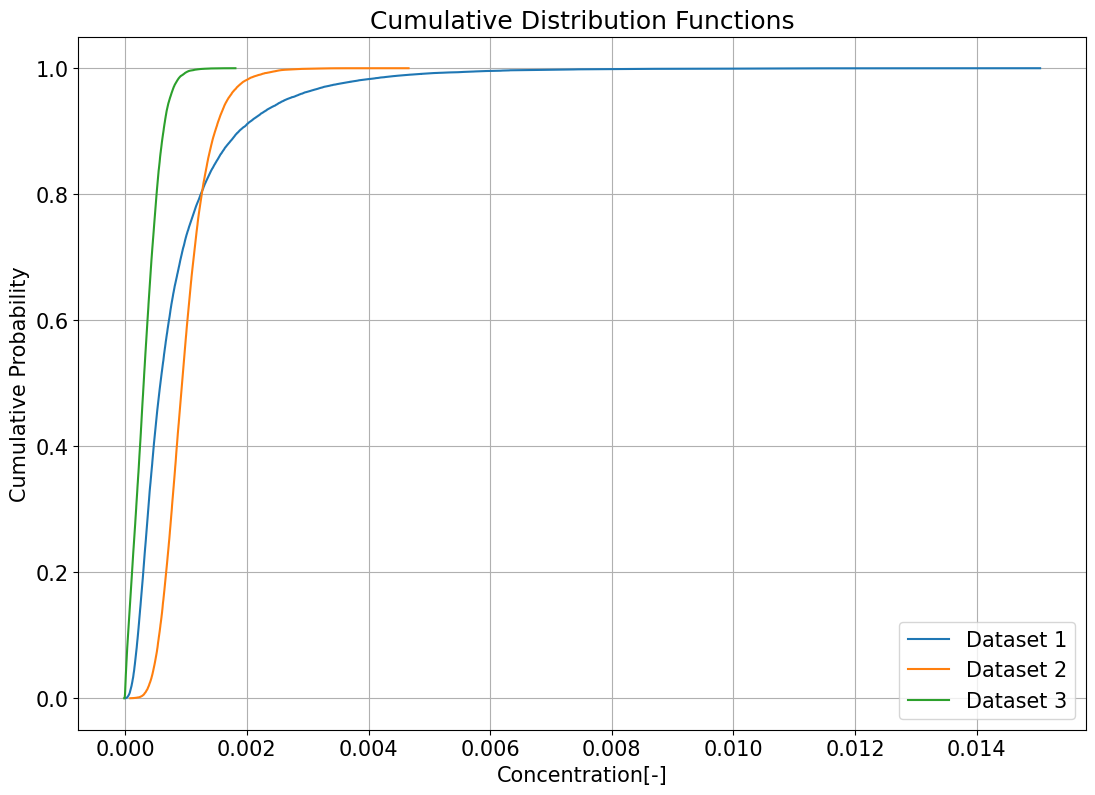

In [36]:
yLabel=None
xLabel="Concentration[-]"
dimensionless="True"
create_cdf(DataPointsConc,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

[array([ 0.      ,  0.390625,  0.78125 ,  1.171875,  1.5625  ,  1.953125,
        2.34375 ,  2.734375,  3.125   ,  3.515625,  3.90625 ,  4.296875,
        4.6875  ,  5.078125,  5.46875 ,  5.859375,  6.25    ,  6.640625,
        7.03125 ,  7.421875,  7.8125  ,  8.203125,  8.59375 ,  8.984375,
        9.375   ,  9.765625, 10.15625 , 10.546875, 10.9375  , 11.328125,
       11.71875 , 12.109375, 12.5     , 12.890625, 13.28125 , 13.671875,
       14.0625  , 14.453125, 14.84375 , 15.234375, 15.625   , 16.015625,
       16.40625 , 16.796875, 17.1875  , 17.578125, 17.96875 , 18.359375,
       18.75    , 19.140625, 19.53125 , 19.921875, 20.3125  , 20.703125,
       21.09375 , 21.484375, 21.875   , 22.265625, 22.65625 , 23.046875,
       23.4375  , 23.828125, 24.21875 , 24.609375, 25.      , 25.390625,
       25.78125 , 26.171875, 26.5625  , 26.953125, 27.34375 , 27.734375,
       28.125   , 28.515625, 28.90625 , 29.296875, 29.6875  , 30.078125,
       30.46875 , 30.859375, 31.25    , 31.640625,

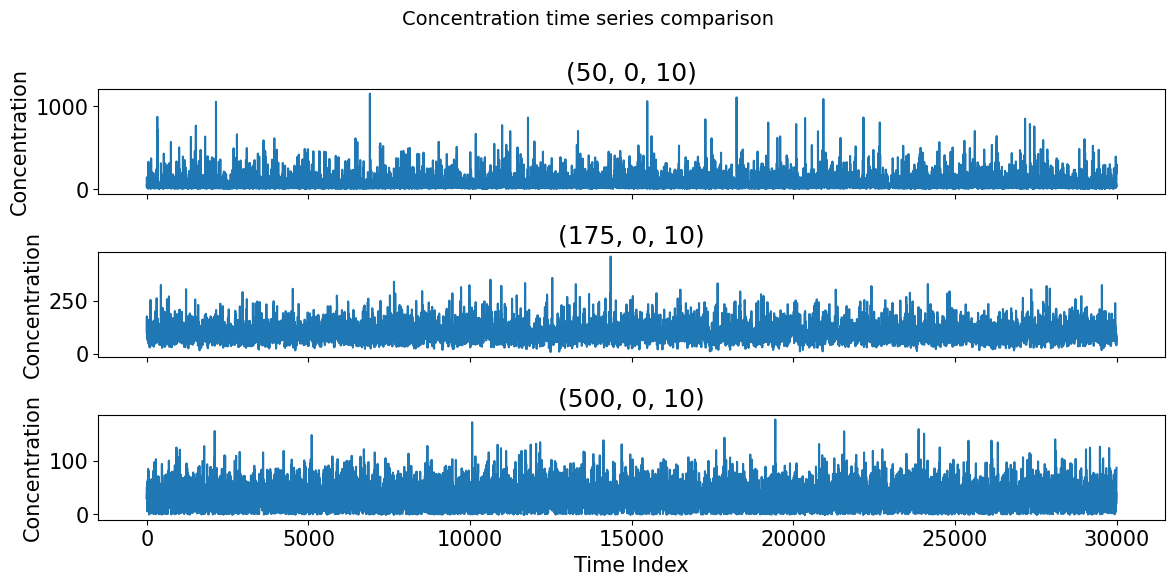

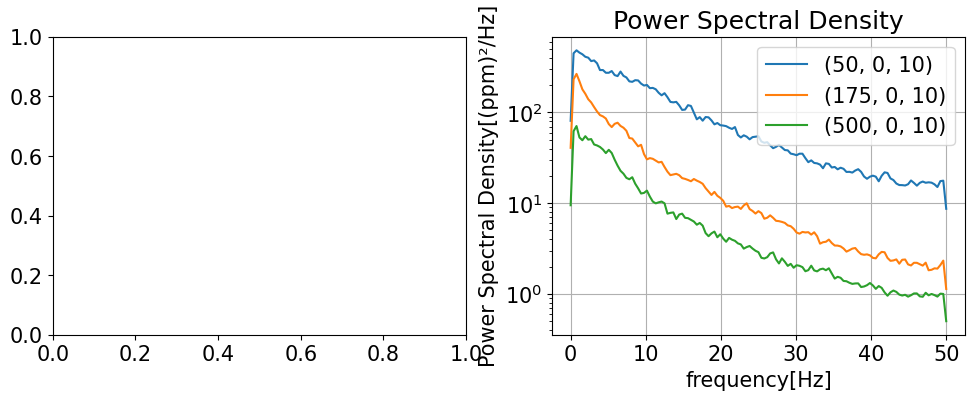

{'peak_frequency': [0.78125, 0.78125, 0.78125], 'fluctuation_intensity': [0.9242225702469893, 0.8460897764681574, 0.8839523590386464], 'std_concentration': 55.81380952392418}


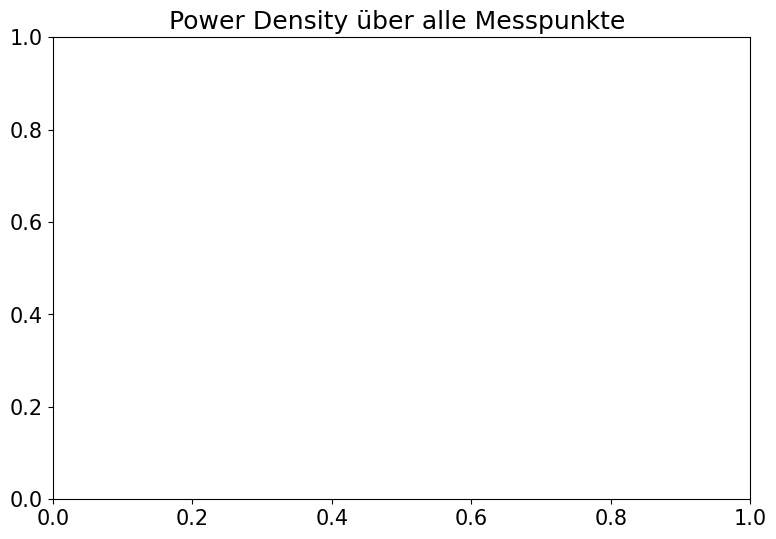

In [37]:
labels = [f"({dp.x:.0f}, {dp.y:.0f}, {dp.z:.0f})"for dp in DataPointsConc]
test = powerDensityPlot(DataPointsConc,dimensionless="False",plot=True,labels=labels,xLabel=None,yLabel=None,xAchse=None,yAchse=None)
plt.title("Power Density über alle Messpunkte ")
plt.savefig("test.png")
print(test)

In [ ]:
#Example of how to load/Read-in averages from file to use f.e. in map or for plotting
from windtunnel.concentration.utils import load_avg_file

file_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/measurements/08.07./results/Point_Data_avg"
file_name = "UBA_thesis__avg_UBA_thesis_007.ts#0"  

full_path = os.path.join(file_path, file_name)
print("Pfad zur Datei:", full_path)
print("Existiert die Datei?", os.path.isfile(full_path))

print(data_dict.keys())
print(data_dict['metadata'].keys())
print(data_dict['metadata']['x (measurement relativ to source)']['value'])
print(data_dict['metadata']['y (measurement relativ to source)']['value'])
print(data_dict['metadata']['z (measurement relativ to source)']['value'])

x = data_dict['metadata']['x (measurement relativ to source)']['value']
y = data_dict['metadata']['y (measurement relativ to source)']['value']
z = data_dict['metadata']['z (measurement relativ to source)']['value']
c = data_dict['data'][0]['net_concentration [ppmV]']

Pfad zur Datei: //Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001_avg_UBA_thesis_test_01072025_001.ts#0
Existiert die Datei? True
dict_keys([])


KeyError: 'metadata'

In [ ]:
full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"

metadata = {}
data = []

with open(full_path, 'r') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        if line.startswith('"'):
            # Kopfzeile mit Variablennamen
            headers = line.replace('"', '').split()
            continue
        # Wertezeile
        values = list(map(float, line.split()))
        data.append(values)

import pandas as pd

df = pd.DataFrame(data, columns=headers)

print(df.head())



In [ ]:
#Start visualisation of map with concentration location and averages, with model in background
pip install numpy_stl


from windtunnel.concentration.utils import stl_to_2d_plot, add_crosses, show_multiple_projections
from windtunnel.concentration.utils import plot_stl_3d, add_crosses_3d
from windtunnel.concentration.utils import add_velocity_field
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Path to your STL file
stl_file = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/20240206_BfS_model_scale_complete.stl"
    
# Define XY coordinates of concentration measurements

#model scale
"""
points = [
   #(-1020,0),
   (-970,-105),
   (930,270),
   (-850,0),
    (15, 25),
    (20, 10),
    (25, 15),
    (30, 30),
    #(x,y)
]
"""

#Read-in from avg files
from windtunnel.concentration.utils import load_avg_file
file_path = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/windtunnel_software/Data/"
file_names = [
    "Point_Data_avg\BFS_BD3_MP01_000_01\_avg_BFS_BD3_MP01_000_01.ts#0",
    "Point_Data_avg\BFS_BD3_MP01_000_01\_avg_BFS_BD3_MP01_000_01.ts#0"
]
points_ms,values_ms, wind_speeds = [],[],[]
for file_name in file_names:
    data_dict = load_avg_file(file_path + file_name)
    x = data_dict['metadata']['x (measurement relativ to source)']['value']
    y = data_dict['metadata']['y (measurement relativ to source)']['value']
    #z.append(data_dict['metadata']['z (measurement relativ to source)']['value'])
    c = data_dict['data'][0]['net_concentration [ppmV]']
    #To test out wind speeds
    wind_speeds.append(data_dict['metadata']['wtref']['value'])
    points_ms.append((x,y))
    values_ms.append(c)
    
ref_position = (0,0)


#####Add velocity field
#Velocity time series values for background overlaying wind field
wind_speeds = [
    0,
    1,
    2,
    3
]
interpolate_windField = True #Interpolate between wind field measurement locations

#Corresponding locations of measured velocites
points_wtref = [
    (-1800,-1800),
    (1800,-1800),
    (-1800,1800),
    (1800,1800)
]


#Average concentration values
values = [9.2484,3.557,72.931, 15, 25, 35, 45]#,c] #[77.262008,
# Define thresholds and corresponding colors
thresholds = [10, 20, 30, 40]
colors = ['blue','green', 'yellow', 'orange', 'red']

#Call stl to polygon print
fig, ax = stl_to_2d_plot(stl_file, projection='xy',toFullScale="False",scaling=1)
#fig, ax = plot_stl_3d(stl_file, azim=0,elev=30,x_range=[-1000,1000],y_range=[-200,200], z_range=[-200,200])
# Add velocity field (speeds only)
add_velocity_field(ax, points_wtref, values=wind_speeds, interpolate=interpolate-windField, grid_density=40, transparencyFactor=0.2,is_latlon=False,toFullScale=False, zorder=5,show_contour_lines=False)
# Add crosses to the plot#
add_crosses(ax, points_ms, values=values_ms, thresholds=thresholds, colors=colors,size=80, linewidth=1.5)
#add_crosses_3d(ax, points, values=values, thresholds=thresholds, colors=colors,size=80, linewidth=1.5)
# Show the plot
ax.set_xlabel("X_ms[mm]")
ax.set_ylabel("Y_ms[mm]")
plt.tight_layout()
plt.savefig("stl_with_crosses.png", dpi=300)
plt.show()

In [ ]:
from windtunnel.concentration.utils import plot_stl_3d, add_crosses_3d, load_data_from_csv
import matplotlib.pyplot as plt
import numpy as np

# Path to your STL file for city structure
stl_file = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/20240711 UBA1c_2.stl"
#Path to csv file containing locations and concentration values measured in format /x,y,z,c
path_file = "/home/sabrina/Schreibtisch/Arbeit_2025/FreeCAD/UBA/loc+value.csv"
points, values = load_data_from_csv(path_file) #File is in full scale 

# Define 3D points for crosses (x, y, z coordinates)
"""
points = [
    (-970, -105, 50),
    (930, 270, 10),
    (-850, 0, 20),
    (15, 25, 30),
    (20, 10, 15),
    (25, 15, 40),
    (30, 30, 60)
]
# Values for color-coding the crosses
values = [9.2484, 3.557, 72.931, 15, 25, 35, 45]
"""

#For full scale trafo
scale = 400

x_range=None#[-30000,30000]#[-20000,-10000]#[-30000,30000]#[-10000,0]#[-30000,30000]
y_range=None#[-45000,45000]#[5000,15000]#[-45000,45000]
#x_range=[-30000,-10000]#[-30000,30000]#[-20000,-10000]#[-30000,30000]#[-10000,0]#[-30000,30000]
#y_range=[30000,50000]#[-45000,45000]#[5000,15000]#[-45000,45000]
z_range=[-15000,20000]
#To Full scale range
#x_range = [i * scale / 1000  for i in x_range] 
#y_range = [i * scale / 1000  for i in y_range] 
#z_range = [i * scale / 1000  for i in z_range]
fig, ax = plot_stl_3d(stl_file,elev=30,azim=320,x_range=x_range,y_range=y_range,z_range=z_range,toFullScale="True",scaling=scale)
#fig, ax = plot_stl_3d(stl_file,elev=0,azim=0)
# Define thresholds and corresponding colors
thresholds = [10, 20, 30, 40] 
thresholds = [i / 10000 for i in thresholds]
colors = ['blue', 'green', 'yellow', 'orange', 'red']

add_crosses_3d(ax, points, values=values, thresholds=thresholds, colors=colors,
              size=80, linewidth=1.5)
plt.tight_layout()
plt.savefig("stl_with_crosses.png", dpi=300)
plt.show()